In [17]:
HEAD_PATH = './'
DATA_PATH = HEAD_PATH + "data/stocks/"
SAVE_PATH = HEAD_PATH + "ckpt/"
TEMP_PATH = SAVE_PATH + "tmp pkl/"
OUTPUT_PATH = HEAD_PATH + 'output'

In [54]:
def get_cross_signal_file_path(DATA_PATH, product_x, product_y):
    return DATA_PATH+product_x+"_"+product_y

In [38]:
def get_product_signal_pkl(HEAD_PATH, product, date):
    
    product_file_path = "{}/data/stocks/{}/{}".format(HEAD_PATH, product, date)# + product_x + date
    
    return load(product_file_path)

In [202]:
def df_compare(df1, df2):
    print("Return unmatched dataframe [Return empty df are the same if they are identical.]")
    return pd.concat([df1, df2]).drop_duplicates(keep=False)


In [198]:
def combine_products(HEAD_PATH, product_x, product_y, file):
    
    data_x = get_product_signal_pkl(HEAD_PATH, product_x, file)
    data_y = get_product_signal_pkl(HEAD_PATH, product_y, file)
    df1 = data_x[["date.time","bid1", "ask1", "next.bid", "next.ask", "adjust", "wpr"]]
    df2 = data_y[["date.time","bid1", "ask1", "next.bid", "next.ask", "adjust", "wpr"]]
    for col in df2.columns:
        if col =='date.time':
            continue
        col_without_digit = ''.join(i for i in col if not i.isdigit())
        df2 = df2.rename(columns={col:"y." + col_without_digit})
    df_tot = pd.concat([df1, df2])
    df_sorted = df_tot.sort_values(['date.time'], ascending=1)
    my_df = df_sorted.ffill().bfill()
    return my_df.reset_index(drop=True)

- Welcome to Quantitative and High Frequency Trading Training Program


In [2]:
from stock_helper import *
from stock_stats import *
from imp import reload   
import stock_helper
import stock_stats
reload(stock_helper)
reload(stock_stats)

<module 'stock_stats' from '/Users/junsu/Dropbox/workspace/stock_week5/src/w3/src/stock_stats.py'>

In [3]:
 
import warnings
 
warnings.filterwarnings('ignore')

- number of cores, set this number according to your computer

In [4]:

#CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM = 8

- sample product, you can change to your specific product symbol

In [5]:
product_list = ["600519", "000858", "000568", "600809", "002304"]

In [6]:
import dask
from dask import compute, delayed

- sample period

In [7]:
period = 4096

- choose an example day

- Now we start our new topics:
- cross-period signal
- cross-symbol signal
- arbitrage

- First, we look at cross-period signal

In [11]:
period_list =  np.power(2, range(10,13))

- we can first generate good index of data
- because loading data each time is too time consuming

In [12]:
# create a all_period signal that is a product of dire_signal_list and range_signal_list

In [13]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
# iterate the signal types
for range_signal in range_signal_list:
    # 
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
len(all_signal_list)
all_period_signal = [signal+".4096" for signal in all_signal_list]

In [14]:
all_period_signal

['nr.4096',
 'dbook.4096',
 'range.pos.4096',
 'price.osci.4096',
 'ma.dif.10.4096',
 'kdj.k.4096',
 'kdj.j.4096',
 'nr.range.4096',
 'dbook.range.4096',
 'range.pos.range.4096',
 'price.osci.range.4096',
 'ma.dif.10.range.4096',
 'kdj.k.range.4096',
 'kdj.j.range.4096',
 'nr.std.4096',
 'dbook.std.4096',
 'range.pos.std.4096',
 'price.osci.std.4096',
 'ma.dif.10.std.4096',
 'kdj.k.std.4096',
 'kdj.j.std.4096',
 'nr.trend.index.4096',
 'dbook.trend.index.4096',
 'range.pos.trend.index.4096',
 'price.osci.trend.index.4096',
 'ma.dif.10.trend.index.4096',
 'kdj.k.trend.index.4096',
 'kdj.j.trend.index.4096']

In [15]:
## parallel generate the distribution of a signal
def par_get_all_signal(signal_name, file_list, product, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file) ## signal
        signal = S
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, SAVE_PATH+"/all signal/"+product+"."+signal_name+".pkl")

- now we compare the result of comb signal and previous signal

- we can see that with atr fitler the result is a little bit worse 
- also we can see that signal of 4096 ticks perform better than combination of signals
- maybe we can use strategies of each period (1024/2048/4096) and then combine them together
- rather than combine them first and then construct strategies
- now we go to cross-symbol signals and arbitrage

In [20]:
# get the signal of two products
product_x = "600519"
product_y = "600809"
date = "2018.pkl"

DATA_PATH_X = "{}/data/stocks/{}/{}".format(HEAD_PATH, product_x, date)# + product_x + date
DATA_PATH_Y = "{}/data/stocks/{}/{}".format(HEAD_PATH, product_y, date)# + product_y + date


data_x = load(DATA_PATH_X)
data_y = load(DATA_PATH_Y)

In [21]:
data_x.columns

Index(['date.time', 'price', 'traded.num', 'turnover', 'qty', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5',
       'bid1.qty', 'bid2.qty', 'bid3.qty', 'bid4.qty', 'bid5.qty', 'ask1.qty',
       'ask2.qty', 'ask3.qty', 'ask4.qty', 'ask5.qty', 'adjust', 'wpr',
       'next.bid', 'next.ask', 'wpr.ret', 'ret', 'min.4096', 'max.4096'],
      dtype='object')

In [22]:
data_x.head(3).to_csv("checkme_stock_pkl.csv")

In [23]:
data_x["date.time"]

0         2018-01-02 09:25:01
1         2018-01-02 09:30:00
2         2018-01-02 09:30:02
3         2018-01-02 09:30:06
4         2018-01-02 09:30:09
                 ...         
973172    2018-12-28 14:56:48
973173    2018-12-28 14:56:51
973174    2018-12-28 14:56:54
973175    2018-12-28 14:56:57
973176    2018-12-28 15:00:00
Name: date.time, Length: 973177, dtype: object

In [24]:
data_y["date.time"]

0         2018-01-02 09:25:03
1         2018-01-02 09:30:02
2         2018-01-02 09:30:06
3         2018-01-02 09:30:09
4         2018-01-02 09:30:15
                 ...         
762014    2018-12-28 14:56:47
762015    2018-12-28 14:56:53
762016    2018-12-28 14:56:56
762017    2018-12-28 14:56:59
762018    2018-12-28 15:00:00
Name: date.time, Length: 762019, dtype: object

In [25]:
os.makedirs(HEAD_PATH+"/comb time", exist_ok=True)
os.makedirs(HEAD_PATH+"/comb time/"+product_x+"_"+product_y, exist_ok=True)

In [26]:
product_x

'600519'

In [27]:
# find all the dates of product x and product y, meaning, which pkl files they have

In [28]:
all_dates_x = os.listdir(DATA_PATH + product_x)
all_dates_y = os.listdir(DATA_PATH + product_y)
all_dates = set(all_dates_x) & set(all_dates_y)
all_dates = np.array(list(all_dates))
all_dates.sort()

In [29]:
all_dates

array(['2011.pkl', '2012.pkl', '2013.pkl', '2014.pkl', '2015.pkl',
       '2016.pkl', '2017.pkl', '2018.pkl', '2019.pkl', '2020.pkl',
       '2021.pkl'], dtype='<U8')

In [61]:
    data_x = get_product_signal_pkl(HEAD_PATH, product_x, date)


#### Dont look at this stupid function

In [30]:
from collections import Counter
def get_stock_comb_pos(date, product_x, product_y, HEAD_PATH):
    '''
    Return a 1-d list with three elements, 0 is the index to be placed in the new sorted array
    sort by time/date
    1 is the boolean to check either the contract is product x or not
    2 is the boolean to check either the contract is product y or not
    '''    
    data_x = get_product_signal_pkl(HEAD_PATH, product_x, date)
    data_y = get_product_signal_pkl(HEAD_PATH, product_y, date)
    
    data_x["contract"] = product_x
    data_y["contract"] = product_y
    comb_time = np.append(data_x["date.time"], data_y["date.time"])
    # sort_index, which is an array, how to use this array?
    # [comb_time[sort_index[0]], comb_time[sort_index[1]], comb_time[sort_index[2]], ..., etc.]
    sort_index = np.argsort(comb_time)
    # comb_time is sorted, by a strange way..
    # comb_time is not used at all
    comb_time = comb_time[sort_index]    
    data = data_x.append(data_y)
    data = data.iloc[sort_index,:]
    time_x = data["contract"]==product_x
    time_y = data["contract"]==product_y
    save([sort_index, time_x, time_y], HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+date)

In [32]:
%%time
result = parLapply(CORE_NUM, all_dates, get_stock_comb_pos, product_x=product_x, product_y=product_y, HEAD_PATH=HEAD_PATH)

#Wall time:  27.1 s

CPU times: user 41.3 ms, sys: 68.9 ms, total: 110 ms
Wall time: 19 s


- let's go to arbitrage

In [35]:
def par_get_stock_arb_all_signal(signal_name, file_list, product_x, product_y, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
        print("LLL")
        S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
        [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
        extend_x = np.append(S_x,S_y)
        extend_x[time_y] = np.nan
        extend_y = np.append(S_x,S_y)
        extend_y[time_x] = np.nan
        extend_x[0] = S_x[0]
        extend_y[0] = S_y[0]
        extend_x = pd.DataFrame(extend_x)
        extend_y = pd.DataFrame(extend_y)
        extend_x.ffill(inplace=True)
        extend_y.ffill(inplace=True)
        signal = np.array((extend_x-extend_y)[0])
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
        return 0
    save(all_signal, HEAD_PATH+"/all signal/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [36]:
%%time
result = par_get_stock_arb_all_signal("kdj.j.4096",  file_list=all_dates, product_x=product_x, 
                   product_y = product_y, period=4096, HEAD_PATH=HEAD_PATH, SAVE_PATH = SAVE_PATH)

# Wall time: 7.86 s

LLL
CPU times: user 157 ms, sys: 47.5 ms, total: 204 ms
Wall time: 227 ms


#### Dont look at this stupid function

In [53]:
def get_combine_data(file, product_x, product_y, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    data_x = get_product_signal_pkl(HEAD_PATH, product_x, file)
    data_y = get_product_signal_pkl(HEAD_PATH, product_y, file)
    
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    # combine two dataframe, and reset their indices
    extend_data_x = data_x.append(data_y)
    extend_data_x = extend_data_x.reset_index(drop=True)
    
    # sort concated product_x signal, and product_y signal
    extend_data_x = extend_data_x.iloc[sort_index]
    extend_data_x = extend_data_x.reset_index(drop=True)
    
    # find product y and set (...) to be np.nan
    extend_data_x.loc[list(time_y), ("bid1", "ask1", "next.bid", "next.ask", "adjust", "wpr")] = np.nan
    
    # use product x first element to ffill 
    extend_data_x.loc[0] = data_x.loc[0]
    extend_data_x.ffill(inplace=True)
    
    
    
    extend_data_y = data_x.append(data_y)
    extend_data_y = extend_data_y.reset_index(drop=True)
    extend_data_y = extend_data_y.iloc[sort_index]
    extend_data_y = extend_data_y.reset_index(drop=True)
    extend_data_y.loc[list(time_x), ("bid1", "ask1", "next.bid", "next.ask", "adjust", "wpr")] = np.nan
    extend_data_y.loc[0] = data_y.iloc[0]
    extend_data_y.ffill(inplace=True)
    
    data = extend_data_x.loc[:,("date.time", "bid1", "ask1", "next.bid", "next.ask", "adjust", "wpr")]
    data["y.bid"] = extend_data_y["bid1"].values
    data["y.ask"] = extend_data_y["ask1"].values
    data["y.next.bid"] = extend_data_y["next.bid"].values
    data["y.next.ask"] = extend_data_y["next.ask"].values
    data["y.adjust"] = extend_data_y["adjust"].values
    data["y.wpr"] = extend_data_y["wpr"].values
    output_path = get_cross_signal_file_path(DATA_PATH, product_x, product_y)
    save(data, os.path.join(output_path, file))

In [55]:
os.makedirs(get_cross_signal_file_path(DATA_PATH, product_x, product_y), exist_ok=True)

%%time
result = parLapply(CORE_NUM, all_dates, get_combine_data, product_x=product_x, product_y = product_y, 
                   HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH);

# Wall time: 34.9 s

#### Start of test

#### This fucking author needs to learn how to write python. Writing up this test to refactor his code.
#### We will call my function to confirm that his code does the same work as my code

In [205]:
# what the author produced
for file in all_dates:
    print(file)
    output_path = get_cross_signal_file_path(DATA_PATH, product_x, product_y)
    df = load(os.path.join(output_path, file))

    print(df_compare(df, combine_products(HEAD_PATH, product_x, product_y, file)))

2011.pkl
Return unmatched dataframe [Return empty df are the same if they are identical.]
Empty DataFrame
Columns: [date.time, bid1, ask1, next.bid, next.ask, adjust, wpr, y.bid, y.ask, y.next.bid, y.next.ask, y.adjust, y.wpr]
Index: []
2012.pkl
Return unmatched dataframe [Return empty df are the same if they are identical.]
Empty DataFrame
Columns: [date.time, bid1, ask1, next.bid, next.ask, adjust, wpr, y.bid, y.ask, y.next.bid, y.next.ask, y.adjust, y.wpr]
Index: []
2013.pkl
Return unmatched dataframe [Return empty df are the same if they are identical.]
             date.time    bid1   ask1  next.bid  next.ask    adjust  \
0  2013-01-04 09:25:01  210.84  212.0    210.05    210.84  1.132283   

          wpr  y.bid  y.ask  y.next.bid  y.next.ask  y.adjust      y.wpr  
0  239.014441  41.66   41.7        41.6       41.66  2.032018  84.733539  
2014.pkl
Return unmatched dataframe [Return empty df are the same if they are identical.]
Empty DataFrame
Columns: [date.time, bid1, ask1, next

Conclusion: how to combine two products? Easy. Just read in signals, then combine them, sort their dates. In the final data frame it has below columns:
 
date.time    bid1   ask1  next.bid  next.ask    adjust  wpr  y.bid  y.ask  y.next.bid  y.next.ask  y.adjust      y.wpr 

the "bid1, ask1, next.bid, next.ask, adjust, wpr" are from "X" product, while the rest are from "Y" product

#### End of test

In [206]:
date_index = 0
input_path = get_cross_signal_file_path(DATA_PATH, product_x, product_y)
base_name = all_dates[date_index]
input_file = os.path.join(input_path, base_name)
data = load(input_file)

In [207]:
data.head(3)

,date.time,bid1,ask1,next.bid,next.ask,adjust,wpr,y.bid,y.ask,y.next.bid,y.next.ask,y.adjust,y.wpr
0,2011-01-04 09:25:05,186.89,186.9,187.0,187.24,1.0,186.891753,68.54,68.6,68.6,68.8,1.0,68.540541
1,2011-01-04 09:25:06,186.89,186.9,187.0,187.24,1.0,186.891753,68.54,68.6,68.6,68.8,1.0,68.540541
2,2011-01-04 09:30:04,186.89,186.9,187.0,187.24,1.0,186.891753,68.60,68.8,68.6,68.8,1.0,68.600000


In [208]:
from collections import OrderedDict
def get_stock_cross_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1,  buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                   max_spread=0.011,HEAD_PATH="d:/intern", SAVE_PATH="e:/intern",
                   atr_filter=0):
    ## load data
    data = load(HEAD_PATH+"/stock pkl/"+product_x+"_"+product_y+"/"+file)
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
    S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
    extend_x = np.append(S_x, S_y)
    extend_x = extend_x[sort_index]
    extend_x[time_y] = np.nan
    extend_x[0] = S_x[0]
    extend_x = pd.DataFrame(extend_x)
    extend_x.ffill(inplace=True)
    atr_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+"atr.4096"+"/"+file).reset_index(drop=True)
    atr_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+"atr.4096"+"/"+file).reset_index(drop=True)
    extend_atr_x = np.append(atr_x, atr_y)
    extend_atr_x = extend_atr_x[sort_index]
    extend_atr_x[time_y] = np.nan
    extend_atr_x[0] = atr_x[0]
    extend_atr_x = pd.DataFrame(extend_atr_x)
    extend_atr_x.ffill(inplace=True)
    atr = extend_atr_x
    S = extend_x
    pred = S*reverse
    pred = pred[0]
    data_x = np.nan
    data_y = np.nan
    date = np.array([x[0:10] for x in data["date.time"]])
    next_date = np.append(date[1:],'1')
    end_day = date!=next_date
    count = 0;
    n_day = sum(end_day)
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((n_day, n_thre))
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0;
    cur_spread = data["y.ask"]-data["y.bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["y.next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["y.next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["y.next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["y.next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base[change_buy] = data["y.next.ask"][change_buy]*(1+buy_tranct)*data["y.adjust"]
        change_base[change_sell] = data["y.next.bid"][change_sell]*(1-sell_tranct)*data["y.adjust"]
        raw_pnl = -(change_base*notional_change_pos).cumsum()+notional_position*data["y.wpr"]
        final_pnl = -sum(change_base*notional_change_pos) ## total pnl, there is a negative sign, because selling get money and buying pay money
        turnover = sum(change_base*abs(notional_change_pos))
        num = sum((notional_position!=0) & (notional_change_pos!=0)) ## number of trades
        hld_period = sum(position!=0)   ## holding period
        daily_pnl = raw_pnl[end_day].reset_index(drop=True)
        pnl = np.append(daily_pnl[0], np.diff(daily_pnl))
        all_pnl[:,thre[0]] = pnl
        if (num==0):
            result.loc[thre[0], ("num","avg.ret","ret")] = (0,0,0)
        else:
            result.loc[thre[0],("num", "avg.ret", "ret", )] = (num, final_pnl/num, final_pnl)
    return OrderedDict([("all.pnl", all_pnl), ("result", result), ("date", date[end_day])])


In [209]:
signal_name = "kdj.j.4096" 

In [210]:
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


In [211]:
from collections import OrderedDict
def get_stock_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2019", reverse=1, 
                                 buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                    max_spread=0.011,  HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", min_pnl=2, min_num=20, atr_filter=0):
    train_sample = all_dates<split_str
    test_sample = all_dates>split_str
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_stock_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, buy_tranct=buy_tranct, sell_tranct=sell_tranct, max_spread=max_spread, 
                                  HEAD_PATH=HEAD_PATH,
                                  SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
        train_result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0]
    train_stat = get_hft_summary(train_result, thre_mat)
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_stock_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                  reverse=reverse, buy_tranct=buy_tranct, sell_tranct=sell_tranct, max_spread=max_spread, 
                                  HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,
                                  atr_filter=atr_filter)
        test_result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0]
    test_stat = get_hft_summary(test_result, thre_mat)
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])

In [212]:
def evaluate_stock_cross_signal(signal, all_dates, product_x, product_y, min_pnl, min_num, HEAD_PATH, SAVE_PATH,
                    CORE_NUM, period=4096, split_str="2018", buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                    max_spread=0.011, atr_filter=0, save_path="signal result"):
    signal_name = signal+"."+str(period)
    all_signal = load(SAVE_PATH+"/all signal/"+product_x+"."+signal_name+".pkl")
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    print("reverse=1")
    trend_signal_stat = get_stock_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str=split_str, reverse=1, 
                    max_spread=max_spread, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    print("reverse=-1")
    reverse_signal_stat = get_stock_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str=split_str, reverse=-1, 
                    max_spread=max_spread, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,  min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
    save(stat_result, HEAD_PATH+"/"+save_path+"/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [213]:
%%time
result = evaluate_stock_cross_signal("kdj.j", np.array(list(all_dates)), product_x,product_y, 2, 20, HEAD_PATH, SAVE_PATH,
                CORE_NUM, period=4096, split_str="2017", atr_filter=0.02, save_path="signal result atr")

# reverse=1
# reverse=-1
# Wall time: 17min 48s






FileNotFoundError: [Errno 2] No such file or directory: './ckpt//all signal/600519.kdj.j.4096.pkl'

In [62]:
%%time
for signal in all_signal_list:
    print(signal)
    result = evaluate_stock_cross_signal(signal, np.array(list(all_dates)), product_x,product_y, 2, 20, HEAD_PATH, SAVE_PATH,
                CORE_NUM, period=4096, split_str="2017", atr_filter=0.02, save_path="signal result atr")

## Wall time: 8h 43min 45s    

nr
reverse=1
reverse=-1
dbook
reverse=1
reverse=-1
range.pos
reverse=1
reverse=-1
price.osci
reverse=1
reverse=-1
ma.dif.10
reverse=1
reverse=-1
kdj.k
reverse=1
reverse=-1
kdj.j
reverse=1
reverse=-1
nr.range
reverse=1
reverse=-1
dbook.range
reverse=1
reverse=-1
range.pos.range
reverse=1
reverse=-1
price.osci.range
reverse=1
reverse=-1
ma.dif.10.range
reverse=1
reverse=-1
kdj.k.range
reverse=1
reverse=-1
kdj.j.range
reverse=1
reverse=-1
nr.std
reverse=1
reverse=-1
dbook.std
reverse=1
reverse=-1
range.pos.std
reverse=1
reverse=-1
price.osci.std
reverse=1
reverse=-1
ma.dif.10.std
reverse=1
reverse=-1
kdj.k.std
reverse=1
reverse=-1
kdj.j.std
reverse=1
reverse=-1
nr.trend.index
reverse=1
reverse=-1
dbook.trend.index
reverse=1
reverse=-1
range.pos.trend.index
reverse=1
reverse=-1
price.osci.trend.index
reverse=1
reverse=-1
ma.dif.10.trend.index
reverse=1
reverse=-1
kdj.k.trend.index
reverse=1
reverse=-1
kdj.j.trend.index
reverse=1
reverse=-1
Wall time: 8h 43min 45s


In [59]:
result = load(HEAD_PATH+"/signal result atr/"+product_x+"_"+product_y+".kdj.j.4096.pkl")

In [65]:
for signal in all_signal_list:
    result = load(HEAD_PATH+"/signal result atr/"+product_x+"_"+product_y+"."+signal+".4096.pkl")
    train_stat =result["trend.signal.stat"]["train.stat"]
    train_sample = all_dates<"2017"
    test_sample = all_dates>"2017"
    train_dates = np.array([pd.to_datetime(d) for d in train_stat["date"]])
    good_strat = (train_stat["final.result"]["avg.ret"]>0.001) & (train_stat["final.result"]["num"]>0)
    if sum(good_strat)>1:
        train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat =result["reverse.signal.stat"]["test.stat"]
        test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
        test_dates = np.array([pd.to_datetime(d) for d in test_stat["date"]])
        format_dates = np.append(train_dates, test_dates)
        pnl = np.append(train_pnl, test_pnl)
        print(signal, sharpe(train_pnl), sharpe(test_pnl))

# nr 0.30270484562199756 0.6861769023637151
# dbook 0.17651237209913737 -1.0816687021231695
# range.pos 0.38590960023261145 1.3789356474056444
# price.osci 0.32467920538804357 -0.3453893068140417
# ma.dif.10 0.23554225387195046 0.7520185513123049
# kdj.k 0.5604279776649883 -0.16945038409409122
# kdj.j 0.5667979503812653 0.7030938991929268
# nr.std 0.0673587834272016 -0.45911405408126027
# dbook.std 0.172390380129705 -0.8270539022318688
# range.pos.std 0.33128417236795177 0.93158203719568
# kdj.k.std 0.35039913590146077 0.262364684388853
# kdj.j.std 0.4061430089189146 0.4941875385988684
# nr.trend.index 0.32205391545383066 0.3959877752609676
# dbook.trend.index 0.13299524611333344 0.2584329748259715
# range.pos.trend.index 0.12633612821217755 0.02449683714403676
# price.osci.trend.index 0.13719151252679093 -1.051340042111566
# ma.dif.10.trend.index 0.3999770340215835 1.3141631522892507
# kdj.k.trend.index 0.19526122865550993 -0.9767377702823877
# kdj.j.trend.index 0.1377935832421713 -0.588953433679374


nr 0.30270484562199756 0.6861769023637151
dbook 0.17651237209913737 -1.0816687021231695
range.pos 0.38590960023261145 1.3789356474056444
price.osci 0.32467920538804357 -0.3453893068140417
ma.dif.10 0.23554225387195046 0.7520185513123049
kdj.k 0.5604279776649883 -0.16945038409409122
kdj.j 0.5667979503812653 0.7030938991929268
nr.std 0.0673587834272016 -0.45911405408126027
dbook.std 0.172390380129705 -0.8270539022318688
range.pos.std 0.33128417236795177 0.93158203719568
kdj.k.std 0.35039913590146077 0.262364684388853
kdj.j.std 0.4061430089189146 0.4941875385988684
nr.trend.index 0.32205391545383066 0.3959877752609676
dbook.trend.index 0.13299524611333344 0.2584329748259715
range.pos.trend.index 0.12633612821217755 0.02449683714403676
price.osci.trend.index 0.13719151252679093 -1.051340042111566
ma.dif.10.trend.index 0.3999770340215835 1.3141631522892507
kdj.k.trend.index 0.19526122865550993 -0.9767377702823877
kdj.j.trend.index 0.1377935832421713 -0.588953433679374


- we can see that strategies in training set can still perform well in test set

In [66]:
## backtest arbitrage signal strategy
## each time buy a product and sell another
## long the pair means long product x and short product y with the same notional value
from collections import OrderedDict
def get_stock_arb_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1, buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                             max_spread_x=0.011, max_spread_y=0.011,HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", 
                             rebate=0, signal_thre=11e-4):
    ## load data
    data = load(HEAD_PATH+"/stock pkl/"+product_x+"_"+product_y+"/"+file)
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    ## load signals
    S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
    S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    extend_x = np.append(S_x,S_y)
    extend_x[time_y] = np.nan
    extend_y = np.append(S_x,S_y)
    extend_y[time_x] = np.nan
    extend_x[0] = S_x[0]
    extend_y[0] = S_y[0]
    extend_x = pd.DataFrame(extend_x)
    extend_y = pd.DataFrame(extend_y)
    extend_x.ffill(inplace=True)
    extend_y.ffill(inplace=True)
    S = np.array((extend_x-extend_y)[0]) ## difference of two signals
    pred = S*reverse
    #pred = pred[data["good"]].reset_index(drop=True)[0]
    data = data.reset_index(drop=True) 
    date = np.array([x[0:10] for x in data["date.time"]])
    next_date = np.append(date[1:],'1')
    end_day = date!=next_date
    count = 0;
    n_day = sum(end_day)
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((n_day, n_thre))
    data_x = np.nan
    data_y = np.nan
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                            ("num", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0;
    cur_spread_x = data["ask1"]-data["bid1"]
    cur_spread_y = data["y.ask"]-data["y.bid"]
    n_bar = len(data)
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        ## long means buy product x at next.ask and sell product y at next bid
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread_y<max_spread_y)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (data["y.next.ask"]>0) & (cur_spread_x<max_spread_x) &
                    (cur_spread_y<max_spread_y)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos_x = pd.Series(data=0, index=data.index)
        notional_position_pos_y = pd.Series(data=0, index=data.index)
        notional_position_pos_x[position_pos==1] = 1
        notional_position_pos_x[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos_y[position_pos==1] = 1
        notional_position_pos_y[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos_x[(notional_position_pos_x==1)] = 1/data["next.ask"][(notional_position_pos_x==1)]
        notional_position_pos_y[(notional_position_pos_y==1)] = -1/data["y.next.bid"][(notional_position_pos_y==1)]
        notional_position_pos_x.ffill(inplace=True)
        notional_position_pos_y.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        ## short means sell product x at next.bid and buy product y at next ask
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread_y<max_spread_y)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread_y<max_spread_y)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg_x = pd.Series(data=0, index=data.index)
        notional_position_neg_y = pd.Series(data=0, index=data.index)
        notional_position_neg_x[position_neg==-1] = -1
        notional_position_neg_x[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg_y[position_neg==-1] = -1
        notional_position_neg_y[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg_x[(notional_position_neg_x==-1)] = -1/data["next.bid"][(notional_position_neg_x==-1)]
        notional_position_neg_y[(notional_position_neg_y==-1)] = 1/data["y.next.ask"][(notional_position_neg_y==-1)]
        notional_position_neg_x.ffill(inplace=True)
        notional_position_neg_y.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position_x = notional_position_pos_x+notional_position_neg_x
        notional_position_y = notional_position_pos_y+notional_position_neg_y
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-10:] = 0
        notional_position_x.iloc[0] = 0
        notional_position_y.iloc[0] = 0
        notional_position_x.iloc[-10:] = 0
        notional_position_y.iloc[-10:] = 0
        notional_change_pos_x = notional_position_x-notional_position_x.shift(1)
        notional_change_pos_y = notional_position_y-notional_position_y.shift(1)
        change_pos = position - position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos_x.iloc[0] = 0
        notional_change_pos_y.iloc[0] = 0
        change_base_x = pd.Series(data=0, index=data.index)
        change_base_y = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base_x[change_buy] = data["next.ask"][change_buy]*(1+buy_tranct)*data["adjust"]
        change_base_x[change_sell] = data["next.bid"][change_sell]*(1-sell_tranct)*data["adjust"]
        change_base_y[change_buy] = data["y.next.bid"][change_buy]*(1-sell_tranct)*data["y.adjust"]
        change_base_y[change_sell] = data["y.next.ask"][change_sell]*(1+buy_tranct)*data["y.adjust"]
        final_pnl = -sum(change_base_x*change_pos)-sum(change_base_y*change_pos)
        ret = -sum(change_base_x*notional_change_pos_x)-sum(change_base_y*notional_change_pos_y)
        raw_pnl = -(change_base_x*notional_change_pos_x).cumsum()+notional_position_x*data["wpr"]-(change_base_y*notional_change_pos_y).cumsum()+notional_position_y*data["y.wpr"]
        num = sum((position!=0) & (change_pos!=0))
        daily_pnl = raw_pnl[end_day].reset_index(drop=True)
        pnl = np.append(daily_pnl[0], np.diff(daily_pnl))
        all_pnl[:,thre[0]] = pnl
        if (num==0):
            result.loc[thre[0], ("num","avg.ret","ret")] = (0,0,0)
        else:
            result.loc[thre[0],("num", "avg.ret", "ret", )] = (num, ret/num, ret)
    return OrderedDict([("all.pnl", all_pnl), ("result", result), ("date", date[end_day])])

In [67]:
signal_name = "kdj.j.4096" 
thre_list = []
#open_list = np.quantile(abs(all_signal), np.arange(0.99991,0.99999,0.00001))
open_list = np.arange(0.003,0.005,0.0001)
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat

,open,close
0,0.0030,-0.00060
1,0.0030,-0.00120
2,0.0030,-0.00180
3,0.0030,-0.00240
4,0.0030,-0.00300
...,...,...
95,0.0049,-0.00098
96,0.0049,-0.00196
97,0.0049,-0.00294
98,0.0049,-0.00392


In [68]:
%%time
train_result = parLapply(CORE_NUM, all_dates[train_sample], get_stock_arb_signal_pnl, product_x=product_x, product_y=product_y, 
                         signal_name="kdj.j.4096", thre_mat=thre_mat, reverse=1, buy_tranct=1.5e-4, sell_tranct=11.5e-4, 
                         max_spread_x=0.011, max_spread_y=0.011, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern")
test_result = parLapply(CORE_NUM, all_dates[test_sample], get_stock_arb_signal_pnl, product_x=product_x, product_y=product_y, 
                        signal_name="kdj.j.4096",
                        thre_mat=thre_mat, reverse=1, buy_tranct=1.5e-4, sell_tranct=11.5e-4, 
                         max_spread_x=0.011, max_spread_y=0.011, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern")
# Wall time: 14min 30s

Wall time: 14min 30s


In [69]:
train_stat = get_hft_summary(train_result, thre_mat)
test_stat = get_hft_summary(test_result, thre_mat)

In [70]:
save(train_stat, HEAD_PATH+"/wine.arb.train.pkl")
save(test_stat, HEAD_PATH+"/wine.arb.test.pkl")

- we can see that there are no good strategies for a-m arbitrage
- the reason may be that oil contracts have too low volatility and intraday trading cannot cover transaction cost


0.19443148750405465 0.23593002125677734


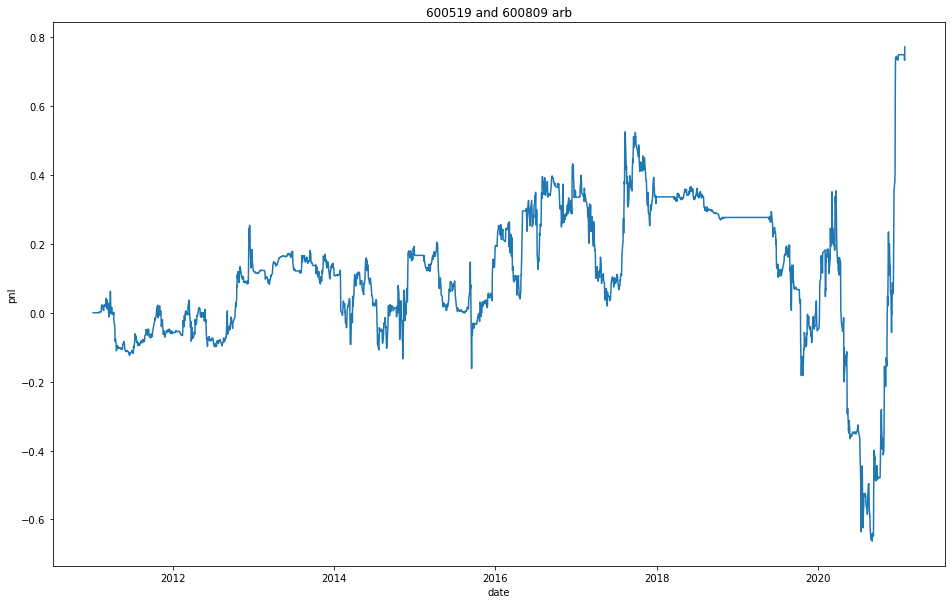

In [71]:
date_str = [n[0:10] for n in all_dates]
train_sample = all_dates<"2017"
test_sample = all_dates>"2017"
good_strat = (train_stat["final.result"]["avg.ret"]>0.001) & (train_stat["final.result"]["num"]>0)
train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
train_dates = np.array([pd.to_datetime(d) for d in train_stat["date"]])
test_dates = np.array([pd.to_datetime(d) for d in test_stat["date"]])
format_dates = np.append(train_dates, test_dates)
pnl = np.append(train_pnl, test_pnl)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title(product_x+" and "+product_y+" arb");
plt.plot(format_dates, pnl.cumsum());
print(sharpe(train_pnl), sharpe(test_pnl))

## 0.19443148750405465 0.23593002125677734
